# RANDOM FOREST REGRESSION

## Hyperparameter Tuning

1. Grid search CV
   n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features-auto,sqrt,log
2. RandomizedSearchCV(faster)
3. HalvingGridSearchCV(progressive resource allocation)

## FEATURE IMPORTANCE 
1. Bar chart on feature importance
2. permutation importance
3. Partial Dependence Plots(PDP)
4. SHAP values - for deeper model interpretability

## DECIDED WORKFLOW
1. Baseline model training
   Here we will train a simple random forest regression and get its initial metrics. We will use this to understand how our model behaved before tuning.
2. Model Evaluation
3. Hyperparameter Tuning
Retraining......
4. Feature Importance Analysis
5. Diagnostic Visualization

In [65]:
import sys, os
sys.path.append(r"C:\Users\elakkiya\json_tutorial\Chennai_Weather_Prediction")
import utils
from IPython.display import HTML, display
display(HTML("<style>.output_scroll {height:auto !important; max-height:none !important;}</style>"))

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
x_train, y_train, x_test, y_test = utils.load_data()
print(x_train.shape, 
      y_train.shape, x_test.shape, y_test.shape)

rf_scaler = utils.load_scaler()
x_train_scaled = rf_scaler.fit_transform(x_train.drop(columns=["date"], errors="ignore"))
x_test_scaled = rf_scaler.transform(x_test.drop(columns=["date"], errors ="ignore"))

x_train_scaled_df = pd.DataFrame(x_train_scaled, 
                                 columns = x_train.drop(columns=["date"], errors = "ignore").columns)
x_test_scaled_df = pd.DataFrame(x_test_scaled, 
                                columns=x_test.drop(columns=["date"], errors ="ignore").columns)
print("Before:", y_train.shape)
print("Before:", y_test.shape)
#Random Forest Regressor expects 1D target array so we can ravel y
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

print("After:", y_train.shape)
print("After: ", y_test.shape)

(3158, 17) (3158, 1) (790, 17) (790, 1)
Before: (3158, 1)
Before: (790, 1)
After: (3158,)
After:  (790,)


## BASELINE MODEL

In [29]:
rf_baseline = RandomForestRegressor(n_estimators = 100, random_state=42, n_jobs=-1) #njobs for paralle computation for speed
rf_baseline.fit(x_train_scaled_df, y_train)
utils.save_model(rf_baseline, "randomforest_regressor_baseline")

Model saved successfully in C:\Users\elakkiya\json_tutorial\Chennai_Weather_Prediction\models\randomforest_regressor_baseline.pkl


randomforest_regressor_baseline Model Evaluation starts...
predicting with randomforest_regressor_baseline...
Calculating Metrics...
Metrics Calculated...
Visualizing randomforest_regressor_baseline


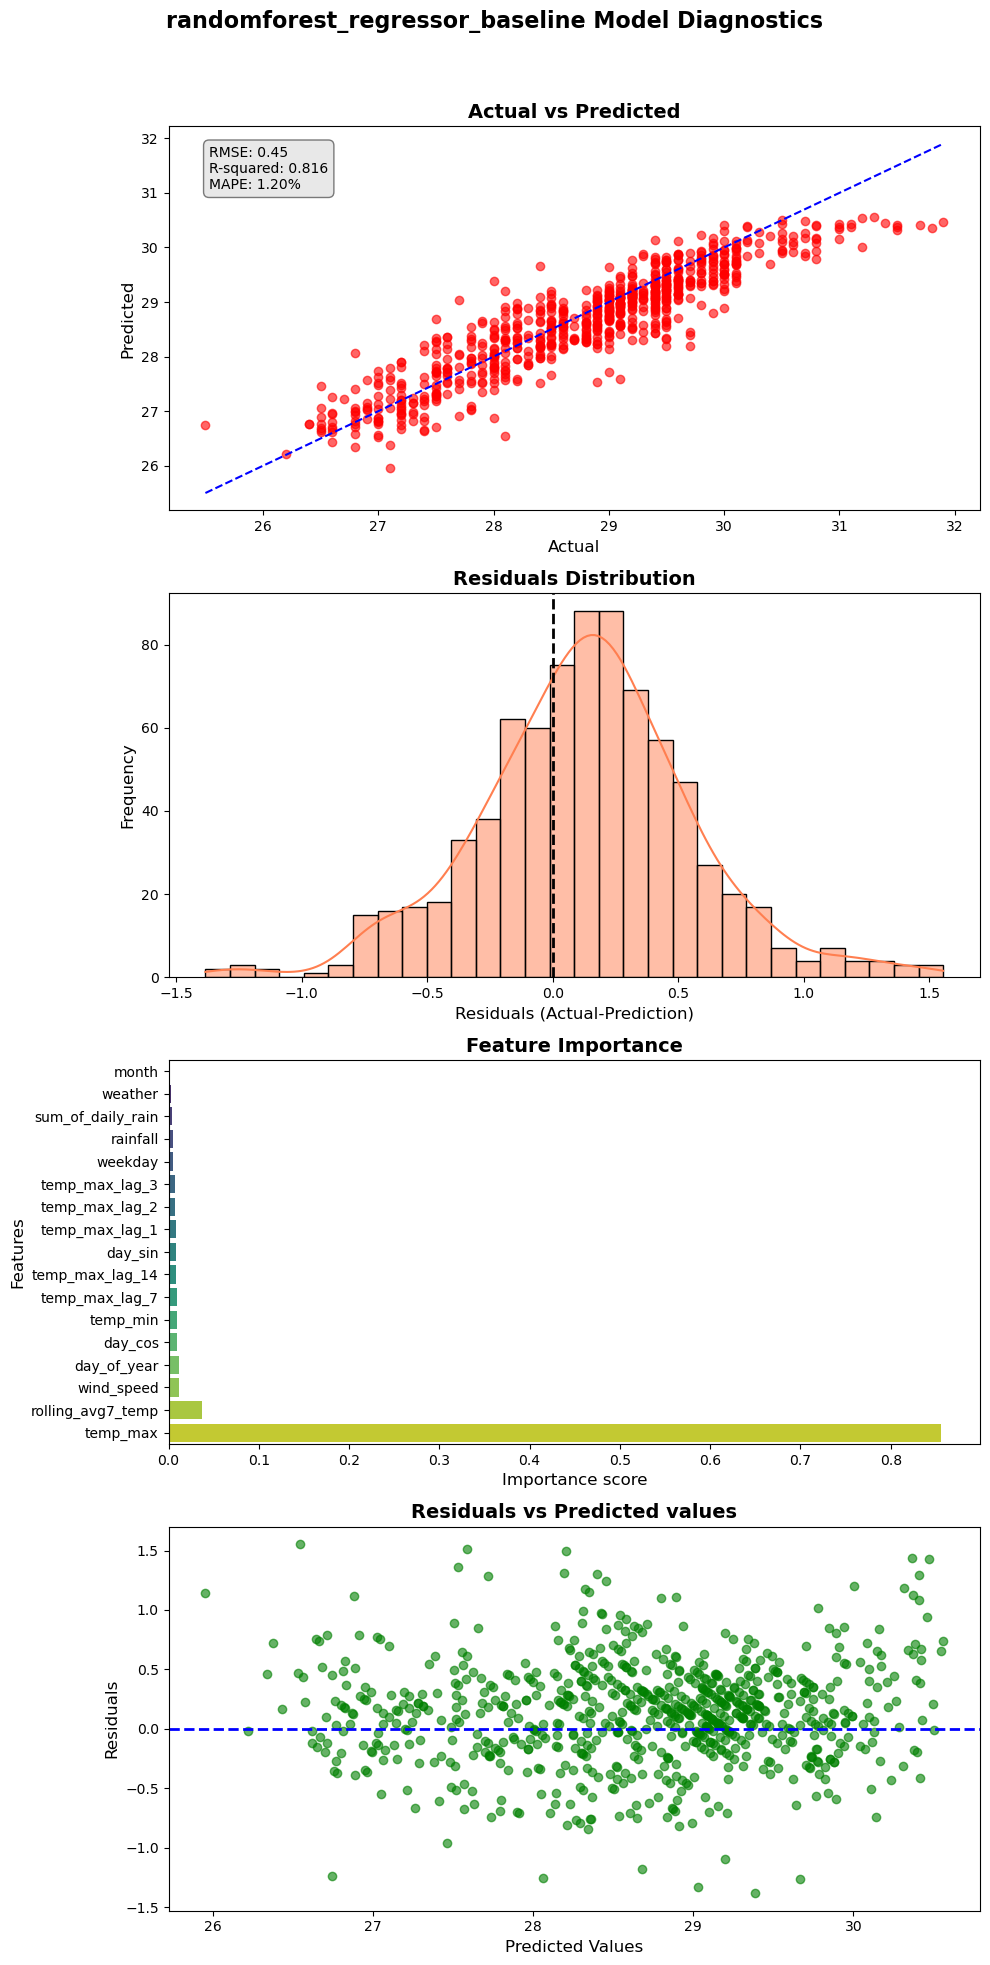

Visualization Done
RMSE: 0.4496289665879386 
r2 score: 0.816 
mape: 1.20


In [4]:
rmse_bl,r2_bl,mape_bl = utils.evaluate_model(x_test_scaled_df, y_test, "randomforest_regressor_baseline")
print(f"RMSE: {rmse_bl} \nr2 score: {r2_bl:.3f} \nmape: {mape_bl:.2f}")

### FORECAST

In [5]:
forecast_results = utils.forecast_next_3_days("randomforest_regressor_baseline", x_test_scaled_df, 3)
print(forecast_results)

Last Date:  2025-11-07 01:28:10.717983
Next Day:  2025-11-08 01:28:10.717983
Next Day:  2025-11-09 01:28:10.717983
Next Day:  2025-11-10 01:28:10.717983
         date  predicted_temp
0  2025-11-08           29.34
1  2025-11-09           29.51
2  2025-11-10           29.54


## RANDOM FOREST REGRESSOR WITH TUNED HYPERPARAMETERS

In [14]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
rf = RandomForestRegressor(random_state=42)

### RANDOMIZEDSEARCHCV  - Exploring the broad search space 

In [30]:
#Defining our parameter Grid
param_grid={
    'n_estimators':[100,200,300,500,800,1000],
    'max_depth':[None, 5,10,15,20,25,30],
    'min_samples_split':[2,5,10],#min samples required to split an internal node
    'min_samples_leaf':[1,2,4],# min samples required to be at a lead nodey
    'max_features':['auto','sqrt','log2'],
    'bootstrap':[True, False]
}
# Initializing the random forest and randomized search CV
"""
our try is with 50 iterations that is random combinations with a 5-fold cv to balance between 
speed and robustness. so that it will be meaningful and impactful
"""

random_search = RandomizedSearchCV(estimator=rf,
                                   param_distributions = param_grid,
                                   n_iter = 50,
                                   cv=5,
                                   verbose=2,
                                   n_jobs = -1,
                                   scoring = "neg_mean_squared_error",
                                   random_state = 42)

# FIT the search
start_time = time.time()
random_search.fit(x_train, y_train)
"""x_train tree  based lke random forest scaling is not required.
np.ravel(y_train) reshapes our 2d array to 1d vector. that is a must for fit compatibility.
"""
end_time = time.time()
elapsed_time = end_time - start_time
print(f"RandomizedSearchCV completed in {elapsed_time/60:.2f} minutes")
print("Best params found", random_search.best_params_)
print(f"Best CV RMSE: {np.sqrt(-random_search.best_score_):.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
RandomizedSearchCV completed in 7.66 minutes
Best params found {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 5, 'bootstrap': True}
Best CV RMSE: 0.3908


In [43]:
utils.save_model(random_search, "random_search_cv_random_forest")

Model saved successfully in C:\Users\elakkiya\json_tutorial\Chennai_Weather_Prediction\models\random_search_cv_random_forest.pkl


In [50]:
results = pd.DataFrame(random_search.cv_results_)#.cv_results_ seen in RidgeCV too
print(results.columns)

results_sorted = results.sort_values(by="mean_test_score", ascending =False)

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_n_estimators', 'param_min_samples_split',
       'param_min_samples_leaf', 'param_max_features', 'param_max_depth',
       'param_bootstrap', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'split4_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')


In [51]:
results.shape

(50, 19)

In [52]:
results_sorted[['param_max_depth', 'mean_test_score']]
print(results_sorted['mean_test_score'].min() - results_sorted['mean_test_score'].max())

-0.13372826711318625


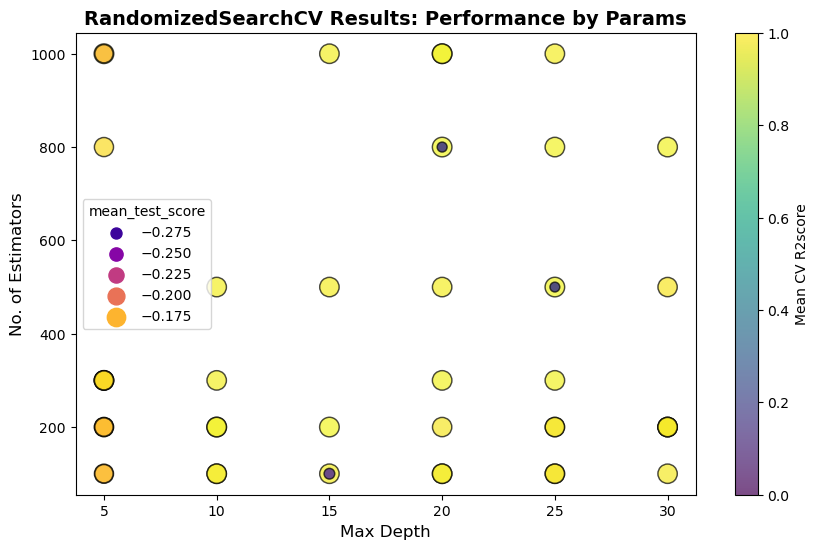

In [47]:
# a bubble scatter plot with brighter the better based on the bubble color to show how good the model is
plt.figure(figsize=(10,6))#width, height
bubble_scatter = sns.scatterplot(data = results_sorted,
                x='param_max_depth',
                y='param_n_estimators',
                hue='mean_test_score',
                palette = 'plasma',
                size='mean_test_score',sizes=(50,200),edgecolor='black',
                alpha=0.7)

cbar = plt.colorbar(bubble_scatter.collections[0], ax=bubble_scatter.figure.axes[0])
cbar.set_label("Mean CV R2score")#.collections[0] as sns.scatterplot uses matplotlib collections and not a direct mappable
plt.title("RandomizedSearchCV Results: Performance by Params", fontsize=14, weight="bold")
plt.xlabel("Max Depth", fontsize=12)
plt.ylabel("No. of Estimators", fontsize=12)
plt.show()

colormap - minimum then maximum R2 value
our viz looks all yellow. lets look into the numbers..

Mean CV test scores - R2 ranges from -0.29 to -0.15
a total variation of only -0.1339 almost identical performance across all paramater settings. That every random forest configuration produced nearly the same model quality. The differences were too tiny for the colormap to distinguish.
Thus it is seen that our model is not sensitive to max_depth in the wider range we explored.
So,
our data is well structured and RF generalizes robustly. Even shallo trees where dept=5 performs almost well as deep ones here. Increasing tree complexity either estimators or depth isnt improving much as possibly reaching the bias variance balance already.

Also our R2 are negative because of how CV evaluates the folds. It happens when the model's predictions are worse than predicting the mean on some folds. Some folds might be small or have less variance. The model hasnt yet been tuned to that fold's (feature,target) pattern. This doesnt mean our overall model is bad. 

Lets see whether after tuning, retaining the best_estimator_ on the full train set gives a positive R2 in our test set.

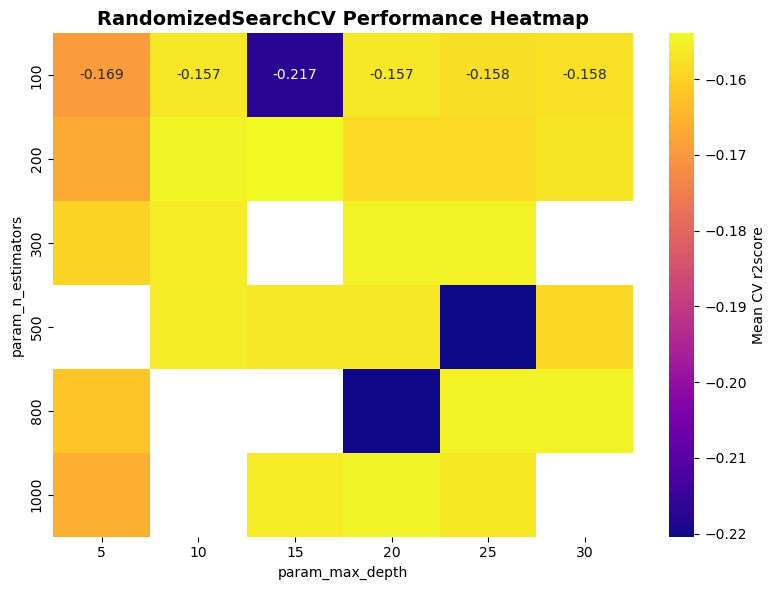

'\nDarker colors weaker performance\nbright colors = orange/yellow - better performance\n\n'

In [18]:
#every parameter combination and it cv score
results_df = pd.DataFrame(random_search.cv_results_)
heatmap_data = results_df.pivot_table(values="mean_test_score",
                                      index="param_n_estimators",#y
                                      columns = "param_max_depth")#x

plt.figure(figsize=(8,6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap='plasma',
            cbar_kws={'label':'Mean CV r2score'})
plt.title("RandomizedSearchCV Performance Heatmap", fontsize=14, weight='bold')
plt.xlabel("param_max_depth")
plt.ylabel("param_n_estimators")
plt.tight_layout()
plt.show()

"""
Darker colors weaker performance
bright colors = orange/yellow - better performance

"""

HEAT MAP INTERPRETATION

x axis is the max_depth that tells us how deep trees can grow
y_axis is the n_estimators that is the number of trees in the forest
bubble colr/size is our R2score(CV)

1 bubble is a combination of (max_dept, n_estimators) tested during our RandomizedSearchCV

With the core of RandomizesSearchCV in finding the region where performance is high,
here the bright yellow and large bubbles. We are taking this as our parameter zones where the RF performed best across CV folds.


Dark blue zones are worst where we can see the max_dept is above and around 20 with estimators 500-800
10-15 max_dept with more than 100 or 150 maybe within and around 500 estimarors giving us the best r2 score ~-0.157 - -0.158.

increasing both parameters doesnt help here. so 
maxdept - 10-15
nestimators 200-500 we can explore this sweet spot more finely.

### GRIDSEARCHCV

In [17]:
param_grid_gcv={
    'n_estimators':[200,300, 400], 
    'max_depth':[8,10,13, 15],
    'min_samples_split':[2,3,4],#min samples required to split an internal node
    'min_samples_leaf':[1,2],# min samples required to be at a lead node
    'max_features':['sqrt']
    #total 3*4*3*2*1 = 72
}
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid_gcv, 
                           cv=5, scoring='r2',verbose=2,n_jobs=-1)
start_time = time.time()
grid_search.fit(x_train, y_train)
end_time = time.time()
elapsed_time= end_time-start_time
print(f"GridSearchCV completed in {elapsed_time/60:.2f} minutes")


Fitting 5 folds for each of 72 candidates, totalling 360 fits
GridSearchCV completed in 5.34 minutes


In [18]:
print("Best params found", grid_search.best_params_)
print(f"Best CV R2: {grid_search.best_score_:.4f}")#we have used scoring r2

"""
IF scoring="neg_root_mean_squared_error"
grid_search.best_score_ would be negative RMSE
print(f"Best CV RMSE: {-grid_search.best_score_:.4f}")
Note:  This is only time when we take the negative or sqrt makes sends if our 
scoring was an MSE or RMSE variant("neg_mean_squared_error", "neg_root_mean_squared_error")
"""

Best params found {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 400}
Best CV R2: 0.8734


'\nIF scoring="neg_root_mean_squared_error"\ngrid_search.best_score_ would be negative RMSE\nprint(f"Best CV RMSE: {-grid_search.best_score_:.4f}")\nNote:  This is only time when we take the negative or sqrt makes sends if our \nscoring was an MSE or RMSE variant("neg_mean_squared_error", "neg_root_mean_squared_error")\n'

In [19]:
#save fit
utils.save_model(grid_search, "grid_search_cv_random_forest")

Model saved successfully in C:\Users\elakkiya\json_tutorial\Chennai_Weather_Prediction\models\grid_search_cv_random_forest.pkl


## GETTING THE BEST MODEL FROM RANDOMSCV and GRIDSCV

In [53]:
best_randomsearch_rf = random_search.best_estimator_
print("Best estimators found", best_randomsearch_rf)

Best estimators found RandomForestRegressor(max_depth=5, max_features='auto', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=300, random_state=42)


In [21]:
best_gridsearch_rf = grid_search.best_estimator_
print("Best estimators found", best_gridsearch_rf)

Best estimators found RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=4,
                      n_estimators=400, random_state=42)


In [22]:
#SAVE THE BEST MODEL WITH BEST ESTIMATOR VALUES
utils.save_model(best_randomsearch_rf, "randomforestregressor_bestrandomsearchcv")
utils.save_model(best_gridsearch_rf, "randomforestregressor_bestgridsearchcv")

Model saved successfully in C:\Users\elakkiya\json_tutorial\Chennai_Weather_Prediction\models\randomforestregressor_bestgridsearchcv.pkl


## BEST MODEL EVALUATION

randomforestregressor_bestrandomsearchcv Model Evaluation starts...
predicting with randomforestregressor_bestrandomsearchcv...
Calculating Metrics...
Metrics Calculated...
Visualizing randomforestregressor_bestrandomsearchcv


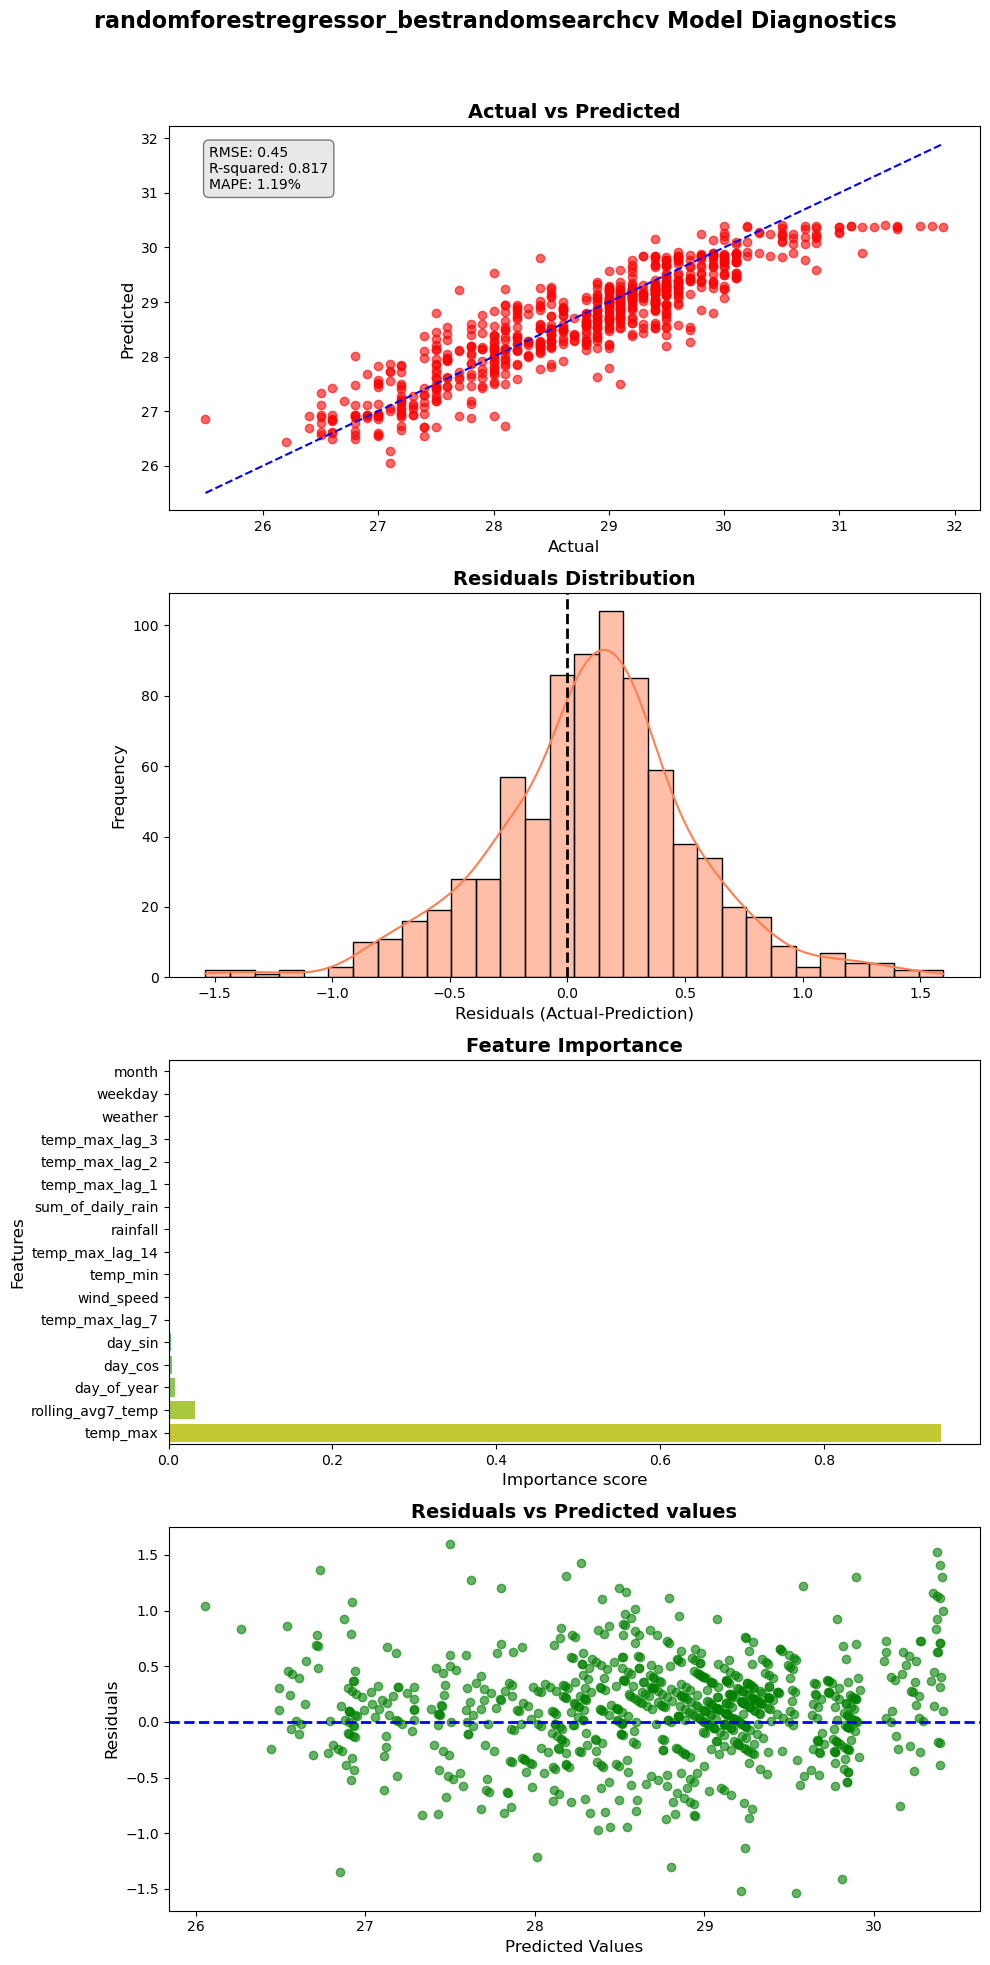

Visualization Done


In [54]:
rmse_rs, r2_rs, mape_rs = utils.evaluate_model(x_test, y_test, name="randomforestregressor_bestrandomsearchcv")

randomforestregressor_bestgridsearchcv Model Evaluation starts...
predicting with randomforestregressor_bestgridsearchcv...
Calculating Metrics...
Metrics Calculated...
Visualizing randomforestregressor_bestgridsearchcv


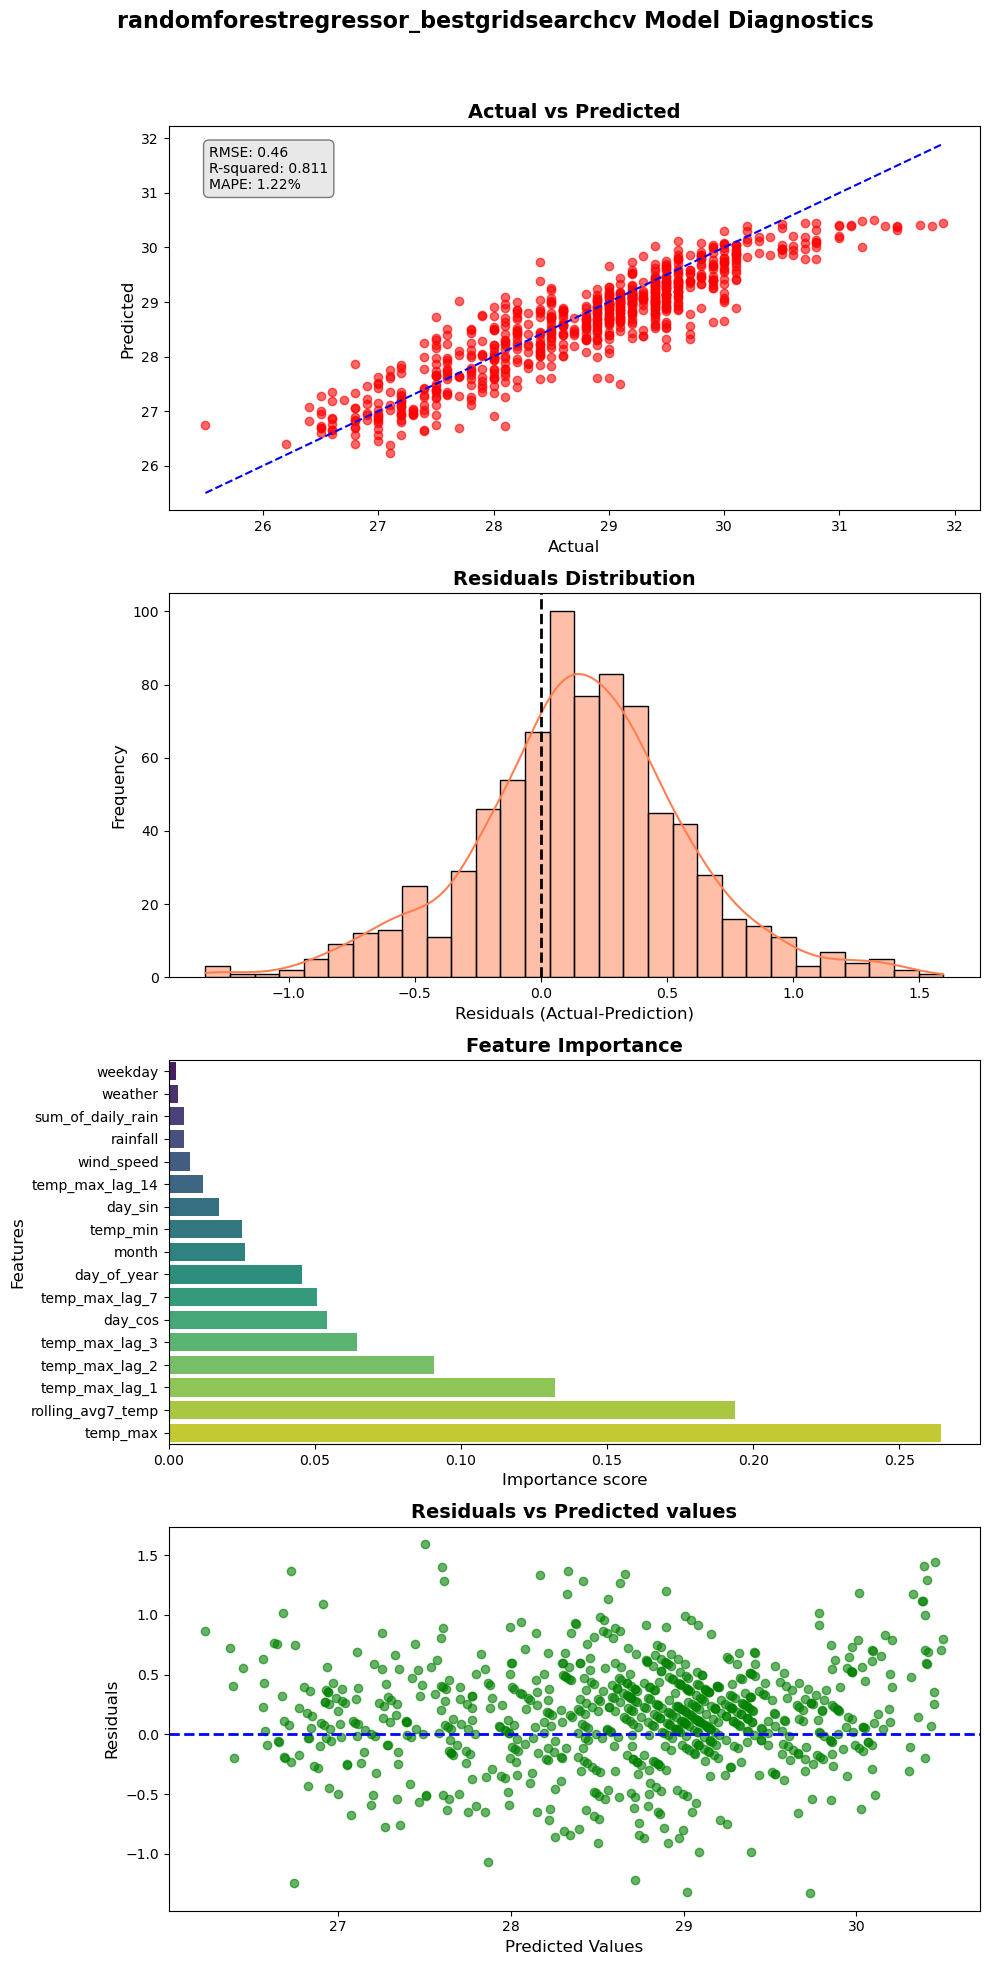

Visualization Done


In [23]:
rmse_gs, r2_gs, mape_gs = utils.evaluate_model(x_test, y_test, name="randomforestregressor_bestgridsearchcv")

In [24]:
metrics_df = pd.DataFrame({"Model":['randomforest_regressor_baseline',
                                    "randomforestregressor_bestrandomsearchcv", 
                                    "randomforestregressor_bestgridsearchcv"],
                           "RMSE":[rmse_bl, rmse_rs,rmse_gs],
                           "R2score":[r2_bl, r2_rs,r2_gs],
                           "MAPE(%)":[mape_bl, mape_rs,mape_gs]
                          })
metrics_df

,Model,RMSE,R2score,MAPE(%)
0,randomforest_regressor_baseline,0.449629,0.816464,1.199515
1,randomforestregressor_bestrandomsearchcv,0.448673,0.817244,1.186163
2,randomforestregressor_bestgridsearchcv,0.456675,0.810666,1.221000


In [25]:
models_list = ['randomforest_regressor_baseline',
               "randomforestregressor_bestrandomsearchcv", 
               "randomforestregressor_bestgridsearchcv"]
overall_rf_forecast_results = []
for model_nm in models_list:
    forecast_df  = utils.forecast_next_3_days(model_nm, x_test, n_days=3)
    forecast_df["Model"] =model_nm
    overall_rf_forecast_results.append(forecast_df)

final_forecast_df = pd.concat(overall_rf_forecast_results, ignore_index=True)
print(final_forecast_df)

Last Date:  2025-11-07 01:44:20.814076
Next Day:  2025-11-08 01:44:20.814076
Next Day:  2025-11-09 01:44:20.814076
Next Day:  2025-11-10 01:44:20.814076
Last Date:  2025-11-07 01:44:20.930004
Next Day:  2025-11-08 01:44:20.930004
Next Day:  2025-11-09 01:44:20.930004
Next Day:  2025-11-10 01:44:20.930004
Last Date:  2025-11-07 01:44:21.144395
Next Day:  2025-11-08 01:44:21.144395
Next Day:  2025-11-09 01:44:21.144395
Next Day:  2025-11-10 01:44:21.144395
         date  predicted_temp                                     Model
0  2025-11-08           30.10           randomforest_regressor_baseline
1  2025-11-09           30.10           randomforest_regressor_baseline
2  2025-11-10           30.10           randomforest_regressor_baseline
3  2025-11-08           29.54  randomforestregressor_bestrandomsearchcv
4  2025-11-09           29.54  randomforestregressor_bestrandomsearchcv
5  2025-11-10           29.54  randomforestregressor_bestrandomsearchcv
6  2025-11-08           28.90    rand

We have implemented a autoregressive forecasting loop with lag shifting logic.
we predict date+1 then roll the predcition forward into lag features which is our autoregressive structure.
we have used our lags 1,2,3,7,14 like a sliding window.

but we find the values suspicious as they give values in one series like 29, 28 and 30.

Really i thought there might be atleast a slight variation day-to-day in each model.

our next input for every iteration might actually be identical to the last original row of our test data
our lag features arent influencing the predictions strongly. as they didnt learn much to rely on them.

if our top features are something else like humidity windspeed and we didnt chage it in the forecastmethod and the model will now have no reason to change its output.

In [11]:
rf_forecast = final_forecast_df.pivot(index="Model",
                                      columns="date",
                                      values= "predicted_temp").reset_index()
rf_forecast

date,Model,2025-11-08,2025-11-09,2025-11-10
0,randomforest_regressor_baseline,30.10,30.10,30.10
1,randomforestregressor_bestgridsearchcv,28.92,28.90,28.90
2,randomforestregressor_bestrandomsearchcv,29.54,29.54,29.54


The vertical offset (28.9, 29.5, 30.1) looks normal.
The flatness across days (same value each day) means our iterative data updates aren’t kicking in properly.

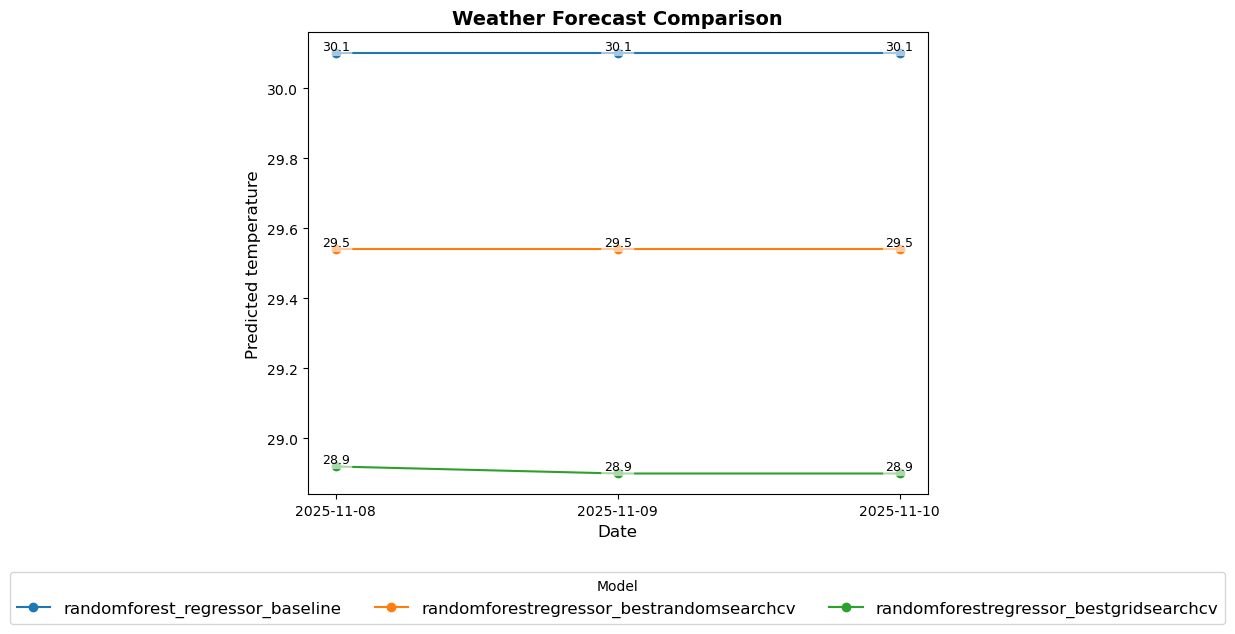

In [59]:
#FORECAST VALUES COMPARISON
plt.figure(figsize=(8,6))
for model in models_list:
    model_data = final_forecast_df[final_forecast_df['Model']==model]
    plt.plot(model_data['date'], model_data['predicted_temp'], marker='o',label=model)
    for x,y in zip(model_data["date"], model_data['predicted_temp']):
        plt.text(x,y,
                 f"{y:.1f}",
                 ha="center",
                 va = 'bottom',
                 fontsize=9, color='black',
                 bbox = dict(facecolor='white',
                             edgecolor='none',
                             alpha=0.6, boxstyle='round,pad=0.2'))
                 

plt.title("Weather Forecast Comparison", fontsize=14, weight="bold")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Predicted temperature", fontsize=12)
plt.legend(title="Model", loc='upper center',
          bbox_to_anchor=(0.5,-0.15),
           ncol= len(models_list),
           fontsize=12)

plt.show()

In [21]:
x_test.tail(3)

,weather,temp_max,temp_min,rainfall,sum_of_daily_rain,wind_speed,day_of_year,month,weekday,day_sin,day_cos,temp_max_lag_1,temp_max_lag_2,temp_max_lag_3,temp_max_lag_7,temp_max_lag_14,rolling_avg7_temp
787,55,28.6,25.8,5.8,5.8,30.4,307,11,0,-0.840618,0.541628,29.1,28.8,29.0,28.5,29.0,28.771429
788,61,28.6,26.4,3.3,3.3,17.3,308,11,1,-0.831171,0.556017,28.6,29.1,28.8,28.0,28.8,28.785714
789,51,29.7,27.6,0.6,0.6,15.0,309,11,2,-0.821477,0.570242,28.6,28.6,29.1,29.0,28.2,28.871429


## FLOW OPTIMIZATION FOR EACH FORECAST ITERATION
as we found flat-line prediction with no day to day variation.
1. temp_max (as next pred)
2. calculating rollin_avg_7_temp
3. leaving out lag14
4. taking the day_of_year and day_cos.


In [62]:
pd.Series(best_randomsearch_rf.feature_importances_,
          index=x_train.columns).sort_values(ascending=False).head(10)

temp_max             0.941171
rolling_avg7_temp    0.035097
day_of_year          0.007358
day_cos              0.004580
day_sin              0.003052
temp_max_lag_7       0.001830
wind_speed           0.001444
temp_min             0.001028
temp_max_lag_14      0.000942
rainfall             0.000941
dtype: float64

In [29]:
pd.Series(best_gridsearch_rf.feature_importances_, 
          index=x_train.columns).sort_values(ascending=False).head(10)

temp_max             0.264339
rolling_avg7_temp    0.193785
temp_max_lag_1       0.132054
temp_max_lag_2       0.090921
temp_max_lag_3       0.064454
day_cos              0.054146
temp_max_lag_7       0.050908
day_of_year          0.045741
month                0.026152
temp_min             0.025225
dtype: float64

In [48]:
def optimized_forecast(model_name, data_df, n_days=3):
    predictions_list=[]
    data = data_df.copy()
    model = utils.load_model(model_name)
    if 'date' in data.columns:
        last_date = pd.to_datetime(data["date"].iloc[-1])
    else:
        last_date = pd.Timestamp.today()
    print(f"Forecasting with model: {model_name}")
    print(f"Last Date: {last_date.strftime('%Y-%m-%d')}")
    for i in range(n_days):
        x_ip = data.tail(1).drop(columns='date', errors='ignore')
        #with the last date from data, we are predicting the next days' temp
        next_pred = model.predict(x_ip)[0]
        next_day = last_date + pd.Timedelta(days=i+1)
        #store the date and temp predicted
        predictions_list.append({
            "date": next_day.strftime("%Y-%m-%d"),
            "predicted_temp": round(next_pred,2)
        })
        #preparing our new addition to the data
        new_row = x_ip.copy()
        new_row["temp_max"] = next_pred
        new_row["temp_max_lag_1"] = next_pred
        new_row["temp_max_lag_2"] = new_row["temp_max_lag_1"]
        new_row["temp_max_lag_3"] = new_row["temp_max_lag_2"]
        new_row["temp_max_lag_7"] = new_row["temp_max_lag_3"]
        #note that we have dropped our lag14
        #creatingw our rolling 7 avg
        new_row["rolling_avg7_temp"]=np.mean([new_row["temp_max_lag_1"],
                                             new_row["temp_max_lag_2"],
                                             new_row["temp_max_lag_3"],
                                             new_row["temp_max_lag_7"]])
        #day based 
        new_row["day_of_year"] = (new_row["day_of_year"]+1)%365
        new_row["day_cos"]=np.cos(2*np.pi*new_row["day_of_year"]/365)
        #NEW ROW
        data = pd.concat([data, new_row], ignore_index=True)
    return pd.DataFrame(predictions_list)

In [56]:
models_list = ['randomforest_regressor_baseline',
               "randomforestregressor_bestrandomsearchcv", 
               "randomforestregressor_bestgridsearchcv"]
overall_rf_forecast_results = []
for model_nm in models_list:
    forecast_df  = optimized_forecast(model_nm, x_test, n_days=3)
    forecast_df["Model"] =model_nm
    overall_rf_forecast_results.append(forecast_df)

final_forecast_df = pd.concat(overall_rf_forecast_results, ignore_index=True)
print(final_forecast_df)


Forecasting with model: randomforest_regressor_baseline
Last Date: 2025-11-07
Forecasting with model: randomforestregressor_bestrandomsearchcv
Last Date: 2025-11-07
Forecasting with model: randomforestregressor_bestgridsearchcv
Last Date: 2025-11-07
         date  predicted_temp                                     Model
0  2025-11-08           30.10           randomforest_regressor_baseline
1  2025-11-09           30.10           randomforest_regressor_baseline
2  2025-11-10           30.10           randomforest_regressor_baseline
3  2025-11-08           29.54  randomforestregressor_bestrandomsearchcv
4  2025-11-09           29.28  randomforestregressor_bestrandomsearchcv
5  2025-11-10           29.14  randomforestregressor_bestrandomsearchcv
6  2025-11-08           28.90    randomforestregressor_bestgridsearchcv
7  2025-11-09           28.61    randomforestregressor_bestgridsearchcv
8  2025-11-10           28.48    randomforestregressor_bestgridsearchcv


In [57]:
rf_forecast = final_forecast_df.pivot(index="Model",
                                      columns="date",
                                      values= "predicted_temp").reset_index()
rf_forecast

date,Model,2025-11-08,2025-11-09,2025-11-10
0,randomforest_regressor_baseline,30.10,30.10,30.10
1,randomforestregressor_bestgridsearchcv,28.90,28.61,28.48
2,randomforestregressor_bestrandomsearchcv,29.54,29.28,29.14


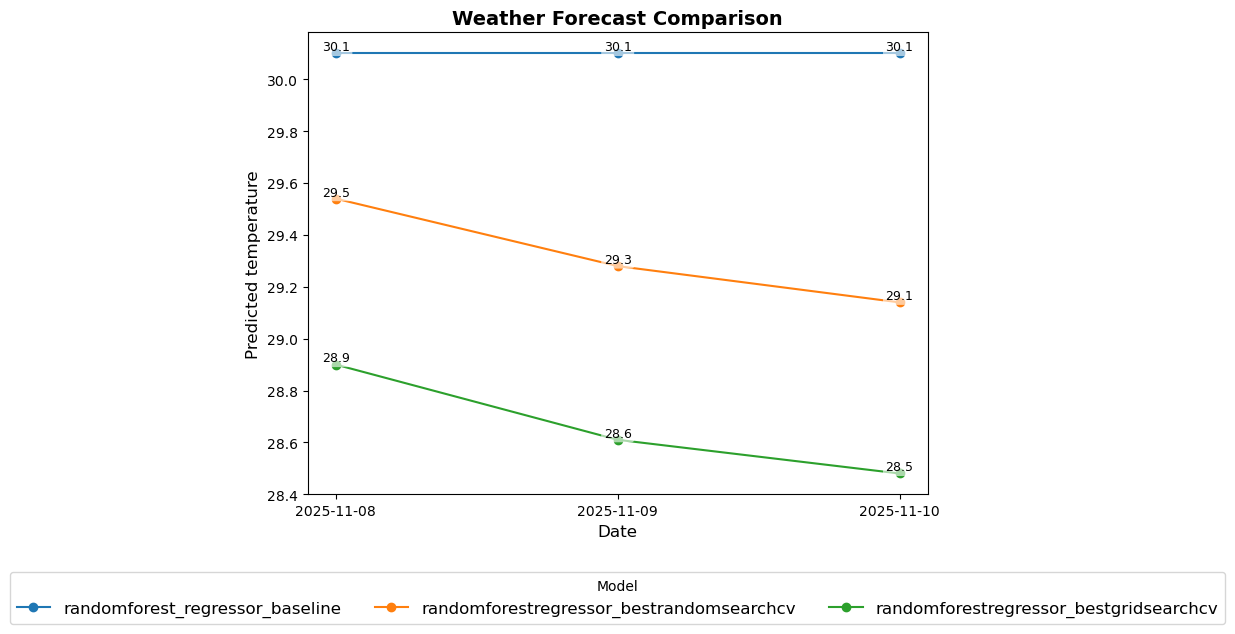

In [58]:
#FORECAST VALUES COMPARISON
plt.figure(figsize=(8,6))
for model in models_list:
    model_data = final_forecast_df[final_forecast_df['Model']==model]
    plt.plot(model_data['date'], model_data['predicted_temp'], marker='o',label=model)
    for x,y in zip(model_data["date"], model_data['predicted_temp']):
        plt.text(x,y,
                 f"{y:.1f}",
                 ha="center",
                 va = 'bottom',
                 fontsize=9, color='black',
                 bbox = dict(facecolor='white',
                             edgecolor='none',
                             alpha=0.6, boxstyle='round,pad=0.2'))
                 

plt.title("Weather Forecast Comparison", fontsize=14, weight="bold")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Predicted temperature", fontsize=12)
plt.legend(title="Model", loc='upper center',
          bbox_to_anchor=(0.5,-0.15),
           ncol= len(models_list),
           fontsize=12)

plt.show()

We can find that the Baseline RF still has Flatline

BestGridSearchCV and

Best RandomSearchCV has agradual cooling trend and smooth downward pattern too.

The temperature trend (small downward drift) is realistic for short-range weather forecasting.

As our baseline is an untuned model, probably less sensitive to lag features we got flat.
Its feature importances are likely dominated by the temp_max var the static last know value and it just
repeates the same prediction for each day

Thus tuning improved temporal sensitivity.
